In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)
import mdtraj_upside as mu

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [5]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [6]:
from itertools import product


def best_hummer_q(traj, native, selection, BETA_CONST, LAMBDA_CONST):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]

    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used

    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`

    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """

    NATIVE_CUTOFF = 0.45  # nanometers

    # get the indices of all of the atoms
    heavy = native.topology.select("resid 0 to 107")
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [
            (i, j)
            for (i, j) in product(selection, heavy)
            if abs(native.topology.atom(i).residue.index - native.topology.atom(j).residue.index) > 3
        ]
    )

    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    # print("Number of native contacts", len(native_contacts))

    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)

    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q

In [7]:
BETA, LAMBDA = 50, 1.8

# try to identify which contacts to use for MSM building

## gs

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/scratch/local/jobs/11538035/ipykernel_4052603/78352537.py:52: RuntimeWarning: overflow encountered in exp
  q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)


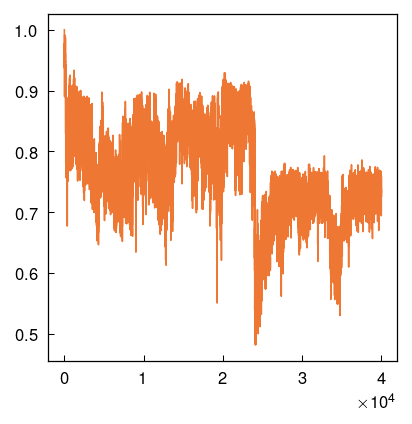

In [8]:
gs_file = "/project2/dinner/darrenjl/kaiB/03022023_restart_trans_gs/run_0/2qke_mutated.run.00.h5"
gs_traj = md.load(gs_file)

selection = gs_traj.top.select("protein")
qfrac = best_hummer_q(gs_traj, gs_traj, selection, BETA, LAMBDA)

plt.plot(qfrac)

In [39]:
# gs_file = "/project2/dinner/darrenjl/kaiB/03022023_restart_trans_gs/run_0/2qke_mutated.run.02.up"
# gs_traj = mu.load_upside_traj(gs_file)

# selection = gs_traj.top.select("protein")
# qfrac = best_hummer_q(gs_traj, gs_traj, selection, BETA, LAMBDA)

# plt.plot(qfrac)

In [9]:
heavy_pairs = np.array(
    [
        (i, j)
        for (i, j) in product(selection, selection)
        if abs(gs_traj.topology.atom(i).residue.index - gs_traj.topology.atom(j).residue.index) > 3
    ]
)
# compute the distances between these pairs in the native state
heavy_pairs_distances = md.compute_distances(gs_traj[0], heavy_pairs)[0]
# and get the pairs s.t. the distance is less than NATIVE_CUTOFF
native_contacts = heavy_pairs[heavy_pairs_distances < 0.45]

In [10]:
len(native_contacts)

1284

In [11]:
r = md.compute_distances(gs_traj, native_contacts)
r0 = md.compute_distances(gs_traj[0], native_contacts)
q = 1.0 / (1 + np.exp(BETA * (r - LAMBDA * r0)))

/scratch/local/jobs/11538035/ipykernel_4052603/69753708.py:3: RuntimeWarning: overflow encountered in exp
  q = 1.0 / (1 + np.exp(BETA * (r - LAMBDA * r0)))


In [12]:
np.mean(q, axis=0)

array([0.5879159 , 0.4882834 , 0.5749499 , ..., 0.81279206, 0.61108524,
       0.5950763 ], dtype=float32)

In [13]:
# and get the pairs s.t. the distance is less than NATIVE_CUTOFF
contact_indices = np.mean(q, axis=0) > 0.5
native_contacts_cutoff = native_contacts[contact_indices]

In [14]:
len(native_contacts_cutoff)

1080

## fs

/scratch/local/jobs/11538035/ipykernel_4052603/78352537.py:52: RuntimeWarning: overflow encountered in exp
  q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)


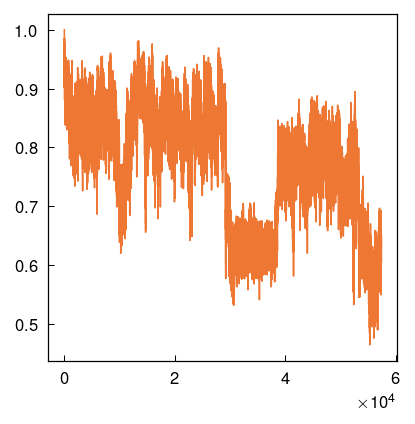

In [44]:
fs_file = "/project2/dinner/darrenjl/kaiB/02272023_cis_fs/run_0/fs_mutated.run.13.h5"
fs_traj = md.load(fs_file)

selection = fs_traj.top.select("protein")
qfrac = best_hummer_q(fs_traj, fs_traj, selection, BETA, LAMBDA)

plt.plot(qfrac)

In [22]:
heavy_pairs = np.array(
    [
        (i, j)
        for (i, j) in product(selection, selection)
        if abs(fs_traj.topology.atom(i).residue.index - fs_traj.topology.atom(j).residue.index) > 3
    ]
)
# compute the distances between these pairs in the native state
heavy_pairs_distances = md.compute_distances(fs_traj[0], heavy_pairs)[0]
# and get the pairs s.t. the distance is less than NATIVE_CUTOFF
native_contacts = heavy_pairs[heavy_pairs_distances < 0.45]

In [23]:
len(native_contacts)

1440

In [24]:
r = md.compute_distances(fs_traj, native_contacts)
r0 = md.compute_distances(fs_traj[0], native_contacts)
q = 1.0 / (1 + np.exp(BETA * (r - LAMBDA * r0)))

/scratch/local/jobs/11538035/ipykernel_4052603/2368700111.py:3: RuntimeWarning: overflow encountered in exp
  q = 1.0 / (1 + np.exp(BETA * (r - LAMBDA * r0)))


In [25]:
# and get the pairs s.t. the distance is less than NATIVE_CUTOFF
contact_indices = np.mean(q, axis=0) > 0.5
native_contacts_cutoff = native_contacts[contact_indices]

In [26]:
len(native_contacts_cutoff)

1176

# PyEMMA featurizer

## number of contacts from list occupied

In [27]:
featurizer = pyemma.coordinates.featurizer(gs_traj.top)

resids = np.array([3, 9, 11, 13, 16, 23, 33, 38, 41, 43, 45, 47, 51, 56, 59, 63, 65, 67, 70, 72, 75, 78, 81, 84, 87, 90, 93]) - 1
residue_pairs = [(i, j) for (i, j) in product(resids, resids) if abs(i - j) > 3 and i > j]
featurizer.add_residue_mindist(residue_pairs=residue_pairs, threshold=0.45)

print(np.count_nonzero(featurizer.describe()))

332


In [28]:
traj_files = [
    "/project2/dinner/darrenjl/kaiB/03022023_restart_trans_gs/run_0/2qke_mutated.run.00.h5",
    "/project2/dinner/darrenjl/kaiB/02272023_cis_fs/run_0/fs_mutated.run.00.h5"
]
features_gs = pyemma.coordinates.load(traj_files, features=featurizer)

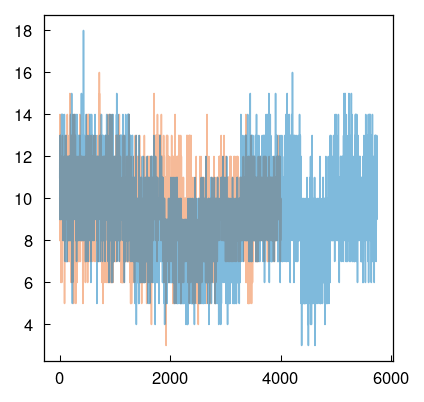

In [29]:
for traj in features_gs:
    plt.plot(np.count_nonzero(traj[::10], axis=1), alpha=0.5)

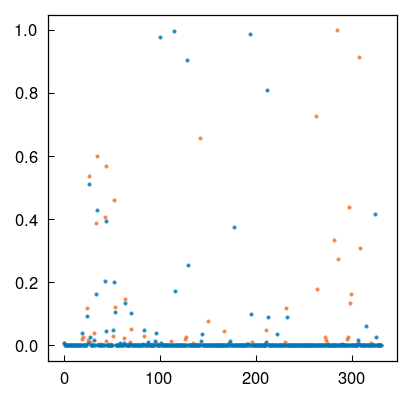

In [30]:
for traj in features_gs:
    feature_occupancy = np.mean(traj, axis=0)
    plt.plot(feature_occupancy, '.', alpha=0.75)

In [31]:
OCCUPANCY_CUTOFF = 0.3
for traj in features_gs:
    feature_occupancy = np.mean(traj, axis=0)
    print(np.count_nonzero(feature_occupancy > OCCUPANCY_CUTOFF))
    for contact_id in np.nonzero(feature_occupancy > OCCUPANCY_CUTOFF)[0]:
        print(featurizer.describe()[contact_id])

13
RES_DIST (closest-heavy) ALA40 - VAL8
RES_DIST (closest-heavy) LYS42 - VAL8
RES_DIST (closest-heavy) LYS42 - LYS10
RES_DIST (closest-heavy) ILE44 - LYS10
RES_DIST (closest-heavy) ILE44 - TYR12
RES_DIST (closest-heavy) VAL46 - TYR12
RES_DIST (closest-heavy) LYS66 - PRO62
RES_DIST (closest-heavy) LEU86 - TYR12
RES_DIST (closest-heavy) LEU86 - SER80
RES_DIST (closest-heavy) LEU89 - LYS10
RES_DIST (closest-heavy) LEU89 - ILE58
RES_DIST (closest-heavy) LEU92 - VAL8
RES_DIST (closest-heavy) LEU92 - LYS10
10
RES_DIST (closest-heavy) ALA40 - VAL8
RES_DIST (closest-heavy) LYS42 - LYS10
RES_DIST (closest-heavy) ILE44 - TYR12
RES_DIST (closest-heavy) PRO62 - TYR12
RES_DIST (closest-heavy) LEU64 - LYS10
RES_DIST (closest-heavy) LYS66 - VAL8
RES_DIST (closest-heavy) PRO71 - LYS66
RES_DIST (closest-heavy) ARG74 - LEU64
RES_DIST (closest-heavy) GLY77 - PRO62
RES_DIST (closest-heavy) LEU92 - LYS66


In [32]:
featurizer_fs = pyemma.coordinates.featurizer(fs_traj.top)

featurizer_fs.add_residue_mindist(threshold=0.45)

print(np.count_nonzero(featurizer_fs.describe()))

22-12-23 13:03:01 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[1] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs
4186


In [33]:
traj_files = [
    "/project2/dinner/darrenjl/kaiB/03022023_restart_trans_gs/run_0/2qke_mutated.run.00.h5",
    "/project2/dinner/darrenjl/kaiB/02272023_cis_fs/run_0/fs_mutated.run.00.h5"
]
features_fs = pyemma.coordinates.load(traj_files, features=featurizer_fs)

getting output of FeatureReader:   0%|          | 0/7 [00:00<?, ?it/s]

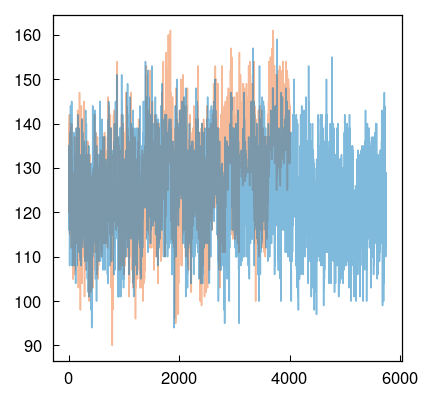

In [34]:
for traj in features_fs:
    plt.plot(np.count_nonzero(traj[::10], axis=1), alpha=0.5)

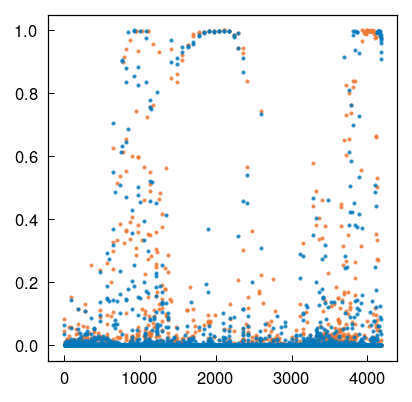

In [35]:
for traj in features_fs:
    feature_occupancy = np.mean(traj, axis=0)
    plt.plot(feature_occupancy, '.', alpha=0.75)

In [36]:
OCCUPANCY_CUTOFF = 0.3
for traj in features_fs:
    feature_occupancy = np.mean(traj, axis=0)
    print(np.count_nonzero(feature_occupancy > OCCUPANCY_CUTOFF))
    contact_ids = np.nonzero(feature_occupancy > OCCUPANCY_CUTOFF)[0]
    for contact_id in contact_ids:
        print(featurizer_fs.describe()[contact_id])

142
RES_DIST (closest-heavy) ALA7 - ALA40
RES_DIST (closest-heavy) ALA7 - LYS42
RES_DIST (closest-heavy) ALA7 - LEU92
RES_DIST (closest-heavy) ALA7 - ALA93
RES_DIST (closest-heavy) VAL8 - ALA40
RES_DIST (closest-heavy) VAL8 - LYS42
RES_DIST (closest-heavy) VAL8 - ARG90
RES_DIST (closest-heavy) VAL8 - LEU91
RES_DIST (closest-heavy) VAL8 - LEU92
RES_DIST (closest-heavy) VAL8 - ALA93
RES_DIST (closest-heavy) LEU9 - ALA40
RES_DIST (closest-heavy) LEU9 - LEU41
RES_DIST (closest-heavy) LEU9 - LYS42
RES_DIST (closest-heavy) LEU9 - VAL43
RES_DIST (closest-heavy) LEU9 - ILE44
RES_DIST (closest-heavy) LEU9 - ARG90
RES_DIST (closest-heavy) LEU9 - LEU91
RES_DIST (closest-heavy) LEU9 - LEU92
RES_DIST (closest-heavy) LYS10 - LYS42
RES_DIST (closest-heavy) LYS10 - ILE44
RES_DIST (closest-heavy) LYS10 - GLY88
RES_DIST (closest-heavy) LYS10 - LEU89
RES_DIST (closest-heavy) LYS10 - ARG90
RES_DIST (closest-heavy) LYS10 - LEU92
RES_DIST (closest-heavy) LEU11 - LYS42
RES_DIST (closest-heavy) LEU11 - VAL43


In [37]:
OCCUPANCY_CUTOFF = 0.5
for traj in features_fs:
    feature_occupancy = np.mean(traj, axis=0)
    print(np.count_nonzero(feature_occupancy > OCCUPANCY_CUTOFF))
    contact_ids = np.nonzero(feature_occupancy > OCCUPANCY_CUTOFF)[0]
    for contact_id in contact_ids:
        print(featurizer_fs.describe()[contact_id])

100
RES_DIST (closest-heavy) ALA7 - ALA40
RES_DIST (closest-heavy) ALA7 - LEU92
RES_DIST (closest-heavy) VAL8 - ALA40
RES_DIST (closest-heavy) VAL8 - ARG90
RES_DIST (closest-heavy) VAL8 - LEU91
RES_DIST (closest-heavy) VAL8 - LEU92
RES_DIST (closest-heavy) LEU9 - ALA40
RES_DIST (closest-heavy) LEU9 - LEU41
RES_DIST (closest-heavy) LEU9 - LYS42
RES_DIST (closest-heavy) LEU9 - ARG90
RES_DIST (closest-heavy) LYS10 - LYS42
RES_DIST (closest-heavy) LYS10 - GLY88
RES_DIST (closest-heavy) LYS10 - LEU89
RES_DIST (closest-heavy) LYS10 - ARG90
RES_DIST (closest-heavy) LEU11 - LYS42
RES_DIST (closest-heavy) LEU11 - VAL43
RES_DIST (closest-heavy) LEU11 - ILE44
RES_DIST (closest-heavy) LEU11 - GLY88
RES_DIST (closest-heavy) TYR12 - ILE44
RES_DIST (closest-heavy) TYR12 - LEU86
RES_DIST (closest-heavy) TYR12 - ILE87
RES_DIST (closest-heavy) TYR12 - GLY88
RES_DIST (closest-heavy) VAL13 - ILE44
RES_DIST (closest-heavy) VAL13 - VAL46
RES_DIST (closest-heavy) VAL13 - LEU47
RES_DIST (closest-heavy) VAL13 

## plot contact maps

Text(0, 0.5, 'fs trajectory')

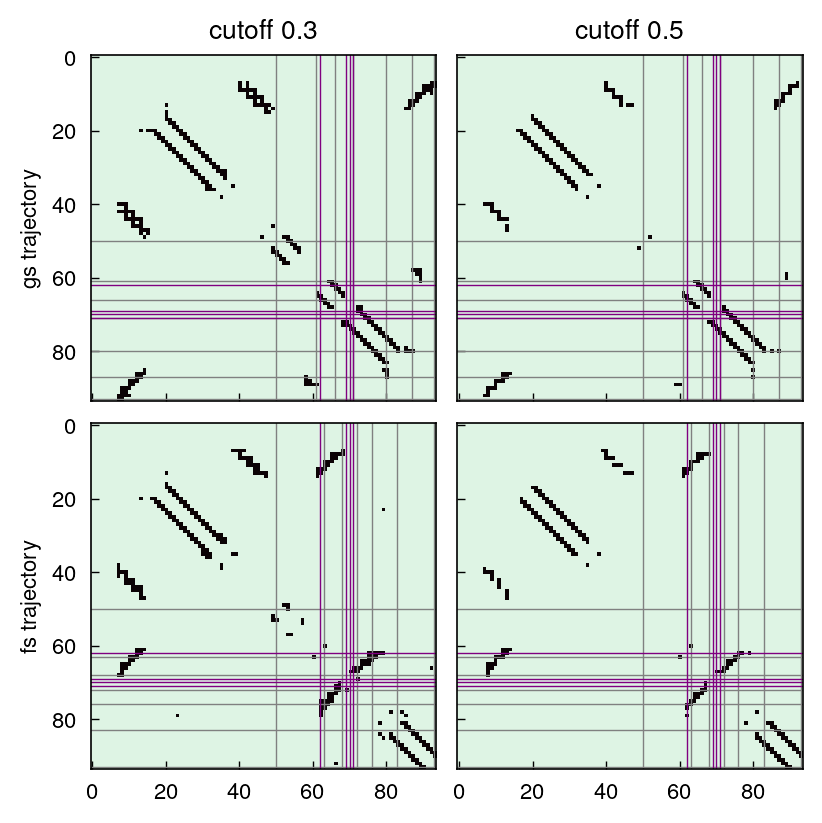

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=200, sharex=True, sharey=True, constrained_layout=True)

# domain boundaries
boundaries_gs = [50, 61, 66, 71, 80, 87, 93]
boundaries_fs = [50, 63, 68, 72, 76, 83, 93]
prolines = [62, 69, 70, 71]
# contact map
for i, traj in enumerate(features_fs):
    for j, cutoff in enumerate([0.3, 0.5]):
        ax = axes[i, j]
        contact_map = np.zeros([94, 94], dtype=int)
        feature_occupancy = np.mean(traj, axis=0)
        contact_ids = np.nonzero(feature_occupancy > cutoff)[0]
        for contact_id in contact_ids:
            feature = featurizer_fs.describe()[contact_id]
            words = feature.split()
            res1, res2 = words[2], words[4]
            # print(res1, res2)
            resid1, resid2 = int(res1[3:]), int(res2[3:])
            contact_map[resid1, resid2] = 1
            contact_map[resid2, resid1] = 1
        ax.imshow(contact_map, cmap="mako_r")
        if i == 0:
            boundaries = boundaries_gs
        else:
            boundaries = boundaries_fs
        for b in boundaries:
            ax.axhline(b, color="gray", lw=0.5)
            ax.axvline(b, color="gray", lw=0.5)
        for p in prolines:
            ax.axhline(p, color="purple", lw=0.5)
            ax.axvline(p, color="purple", lw=0.5)
axes[0, 0].set_title("cutoff 0.3")
axes[0, 1].set_title("cutoff 0.5")
axes[0, 0].set_ylabel("gs trajectory")
axes[1, 0].set_ylabel("fs trajectory")

Text(0.5, 1.0, 'cutoff 0.5')

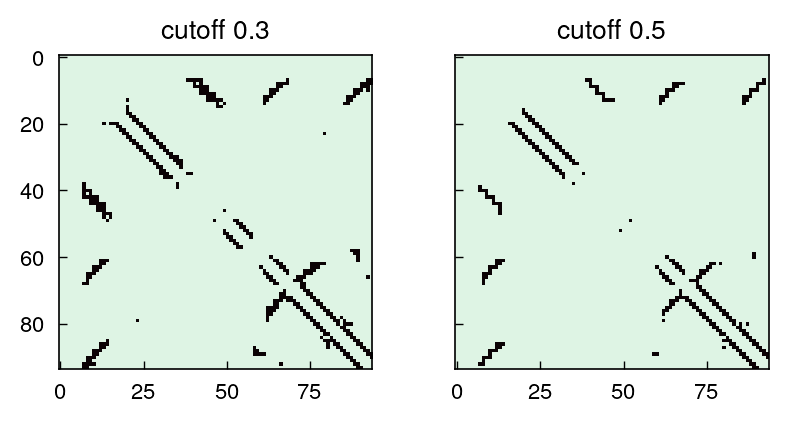

In [60]:
# union of gs and fs contacts
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=200, sharex=True, sharey=True, constrained_layout=True)

# domain boundaries
boundaries_gs = [50, 61, 66, 71, 80, 87, 93]
boundaries_fs = [50, 63, 68, 72, 76, 83, 93]
prolines = [62, 69, 70, 71]
# contact map
for ax, cutoff in zip(axes, [0.3, 0.5]):
    contact_map = np.zeros([94, 94], dtype=int)
    for traj in features_fs:
        feature_occupancy = np.mean(traj, axis=0)
        contact_ids = np.nonzero(feature_occupancy > cutoff)[0]
        for contact_id in contact_ids:
            feature = featurizer_fs.describe()[contact_id]
            words = feature.split()
            res1, res2 = words[2], words[4]
            # print(res1, res2)
            resid1, resid2 = int(res1[3:]), int(res2[3:])
            contact_map[resid1, resid2] = 1
            contact_map[resid2, resid1] = 1
    ax.imshow(contact_map, cmap="mako_r")
axes[0].set_title("cutoff 0.3")
axes[1].set_title("cutoff 0.5")

In [49]:
np.count_nonzero(contact_map)

306

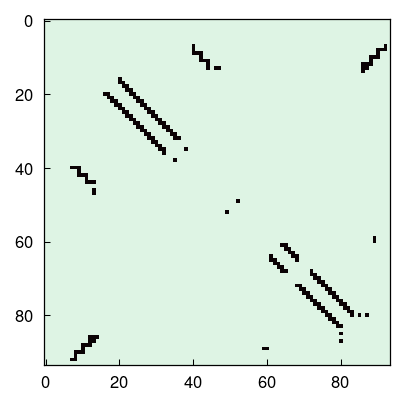

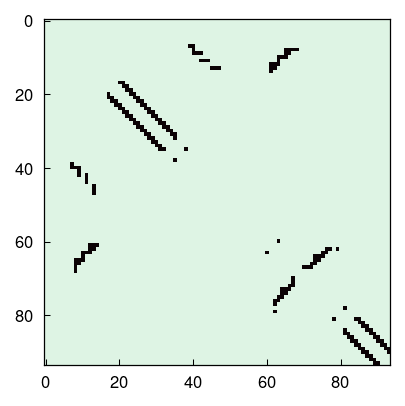

In [39]:
# contact map
OCCUPANCY_CUTOFF = 0.5
for traj in features_fs:
    contact_map = np.zeros([94, 94], dtype=int)
    feature_occupancy = np.mean(traj, axis=0)
    contact_ids = np.nonzero(feature_occupancy > OCCUPANCY_CUTOFF)[0]
    for contact_id in contact_ids:
        feature = featurizer_fs.describe()[contact_id]
        words = feature.split()
        res1, res2 = words[2], words[4]
        # print(res1, res2)
        resid1, resid2 = int(res1[3:]), int(res2[3:])
        contact_map[resid1, resid2] = 1
        contact_map[resid2, resid1] = 1
    fig = plt.figure()
    plt.imshow(contact_map, cmap="mako_r")

## try analyzing trajectories with contacts

In [50]:
n_rep = 48  # replica number

output_names = [
    "gs_d91r",
    "fs_d91r",
    "d91r_05_31",
    "d91r_06_00",
    "remd_d91r_06_00_23_34423",
    "remd_d91r_06_00_19_42383",
    "remd_d91r_06_00_21_33547",
    "remd_d91r_06_00_25_30869",
]
output_dirs = ["gs_p2.5", "fs_p2.5", "05_31", "06_00", "rerun_0", "rerun_1", "rerun_2", "rerun_3"]
work_dir = "/project/dinner/scguo/kaiB/remd/d91r_iso"

In [57]:
traj_files = []
for d, n in zip(output_dirs, output_names):
    for i in np.arange(n_rep):
        j = str(i).zfill(2)
        trajfile = f"{work_dir}/{d}/{n}.run.{j}.h5"
        traj_files.append(trajfile)

In [61]:
OCCUPANCY_CUTOFF = 0.3
def make_contact_list(cutoff):
    contact_ids = []
    for traj in features_fs:
        feature_occupancy = np.mean(traj, axis=0)
        print(np.count_nonzero(feature_occupancy > cutoff))
        contact_ids.append(feature_occupancy > cutoff)
    all_contact_ids = np.nonzero(contact_ids[0] | contact_ids[1])[0]
    print(len(all_contact_ids))
    contact_list = []
    for contact_id in all_contact_ids:
        feature = featurizer_fs.describe()[contact_id]
        words = feature.split()
        res1, res2 = words[2], words[4]
        # print(res1, res2)
        resid1, resid2 = int(res1[3:]), int(res2[3:])
        contact_list.append([resid1, resid2])
    contact_list = np.array(contact_list)
    print(contact_list.shape)
    return contact_list

contact_list = make_contact_list(OCCUPANCY_CUTOFF)

142
130
213
(213, 2)


In [62]:
top = md.load_frame("/project/dinner/scguo/kaiB/remd/d91r_iso/gs_p2.5/gs_d91r.run.00.h5", 0).top
featurizer_contacts = pyemma.coordinates.featurizer(top)
featurizer_contacts.add_residue_mindist(residue_pairs)
remd_contacts = pyemma.coordinates.load(traj_files, features=featurizer_contacts, chunksize=128)

Obtaining file info:   0%|          | 0/384 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/132912 [00:00<?, ?it/s]